In [1]:
# Major Macro / Monetary Regime Events (Overlay Helper)

MACRO_EVENTS = {
    "1873-01-01": "Gold Std Crisis",
    "1914-08-01": "WWI Shock",
    "1933-04-01": "Gold Confiscation",
    "1944-07-01": "Bretton Woods Start",
    "1971-08-15": "Bretton Woods End",
    "1979-10-01": "Volcker Shock",
    "2008-09-15": "GFC",
    "2020-03-01": "COVID Liquidity Shock",
}

def overlay_macro_events(ax, alpha=0.25):
    ymin, ymax = ax.get_ylim()
    for d, label in MACRO_EVENTS.items():
        d = pd.to_datetime(d)
        ax.axvline(d, color="black", linestyle="--", alpha=alpha, linewidth=1)
        ax.text(
            d,
            ymax * 0.98,
            label,
            rotation=90,
            va="top",
            ha="right",
            fontsize=8,
            alpha=0.7,
        )

# 0. Setup

import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = Path("..").resolve()
SRC_PATH = PROJECT_ROOT / "src"
sys.path.insert(0, str(SRC_PATH))

from cycle_tda.selection import select_embedding_params
from cycle_tda.rolling import rolling_ph
from cycle_tda.metrics import summarize_series, usability_score

# 0A. Robust Series Loader (FINAL)

def load_series_auto(path: Path) -> pd.Series:
    df = pd.read_csv(path)

    # detect date column
    date_col = None
    for c in df.columns:
        if c.lower() == "date":
            date_col = c
            break

    # fallback: first column if datetime-like
    if date_col is None:
        first = df.columns[0]
        parsed = pd.to_datetime(df[first], errors="coerce")
        if parsed.notna().mean() > 0.9:
            date_col = first

    if date_col is None:
        raise ValueError(f"{path.name}: no recognizable date column")

    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

    value_cols = [c for c in df.columns if c != date_col]
    if len(value_cols) != 1:
        raise ValueError(
            f"{path.name}: expected 1 value column, found {value_cols}"
        )

    return (
        df
        .set_index(date_col)[value_cols[0]]
        .sort_index()
        .dropna()
    )


In [2]:
# Forecast Eligibility (STRUCTURAL GATE, maybe use)

def forecast_eligibility(z1, q_on=0.75, q_off=0.50):
    hi = z1.quantile(q_on)
    lo = z1.quantile(q_off)

    out = pd.Series(index=z1.index, dtype=int)
    out[z1 >= hi] = 1
    out[z1 <= lo] = -1
    out[(z1 > lo) & (z1 < hi)] = 0
    return out

# 1. Config

ASSETS = {
    "Gold (XAU)": "XAU_Monthly.csv",
    "Silver": "XAG_Monthly.csv",
    "US CPI": "CPI_Monthly.csv",
    "US M2": "M2_Monthly.csv",
    "Fed Funds": "FEDFUNDS_Monthly.csv",
    "HY OAS": "HY_OAS_Monthly.csv",
}

BASE_WINDOW = 60
STRIDE = 1
POST_1971 = "1971-01-01"

MAX_TAU = 60
MAX_M = 12
FNN_THRESHOLD = 5.0
TAU_CAP_FRAC = 10
MIN_POINTS = 20

In [3]:
# 2. Run PH Across Assets

results = []
log_rows = []

for asset, filename in ASSETS.items():
    print(f"\n=== {asset} ===")
    path = PROJECT_ROOT / "data/raw" / filename

    if not path.exists():
        log_rows.append({"asset": asset, "status": "missing"})
        continue

    series = load_series_auto(path)

    # log only when valid
    if (series <= 0).any():
        print("⚠️ non-positive values — skipping log")
    else:
        series = np.log(series)

    if len(series) < 200:
        log_rows.append({"asset": asset, "status": "too_short"})
        continue

    tau_cap = max(1, BASE_WINDOW // TAU_CAP_FRAC)
    tau, m, _ = select_embedding_params(
        series.values,
        max_tau=MAX_TAU,
        max_m=MAX_M,
        fnn_threshold=FNN_THRESHOLD,
        tau_cap=tau_cap,
    )

    window = max(BASE_WINDOW, (m - 1) * tau + 1)
    points = window - (m - 1) * tau

    if points < MIN_POINTS:
        log_rows.append({"asset": asset, "status": "embedding_failed"})
        continue

    # --- Full history ---
    df_full = rolling_ph(series, window, STRIDE, m, tau)
    df_full["forecast_state"] = forecast_eligibility(df_full["z1"])
    df_full["asset"] = asset
    df_full["era"] = "Full"
    df_full["window"] = window
    results.append(df_full)

    # --- Post-1971 ---
    s71 = series[series.index >= POST_1971]
    if len(s71) >= window + 5:
        df_71 = rolling_ph(s71, window, STRIDE, m, tau)
        df_71["forecast_state"] = forecast_eligibility(df_71["z1"])
        df_71["asset"] = asset
        df_71["era"] = "Post-1971"
        df_71["window"] = window
        results.append(df_71)

    log_rows.append({"asset": asset, "status": "ok"})

df_all = pd.concat(results)
log_df = pd.DataFrame(log_rows)
log_df


=== Gold (XAU) ===

=== Silver ===

=== US CPI ===

=== US M2 ===

=== Fed Funds ===

=== HY OAS ===


,asset,status
0,Gold (XAU),ok
1,Silver,ok
2,US CPI,ok
3,US M2,ok
4,Fed Funds,ok
5,HY OAS,ok


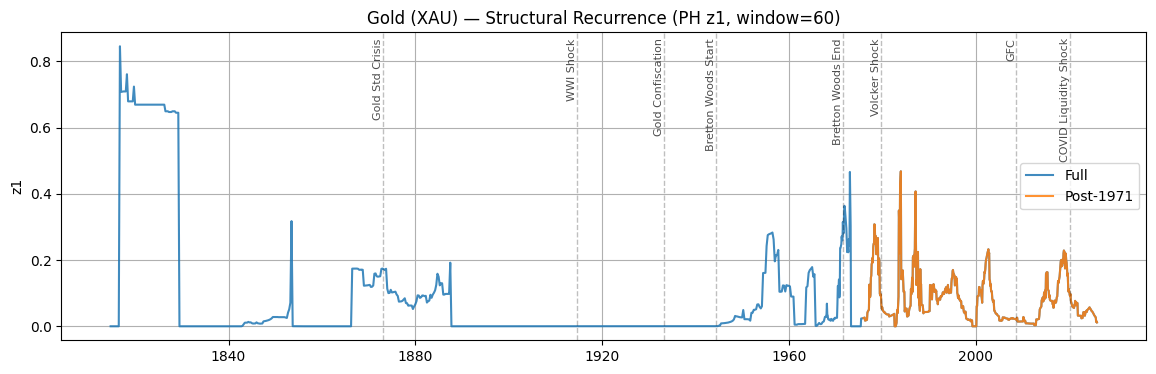

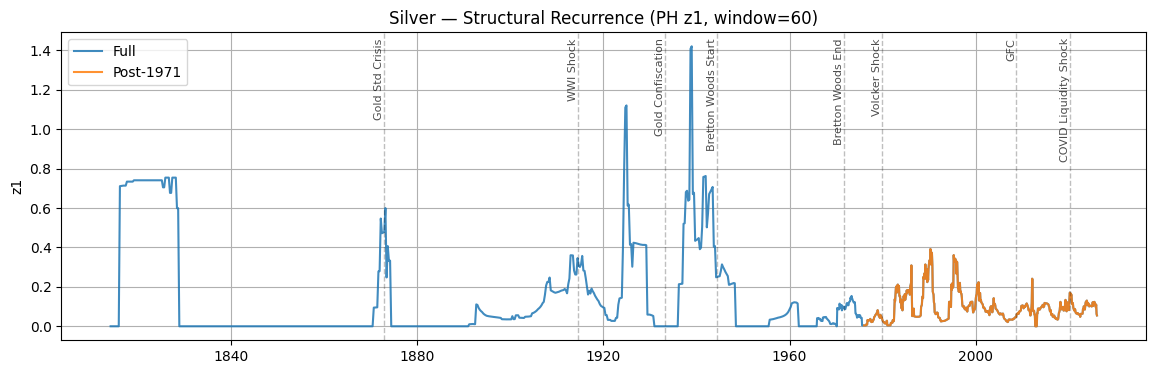

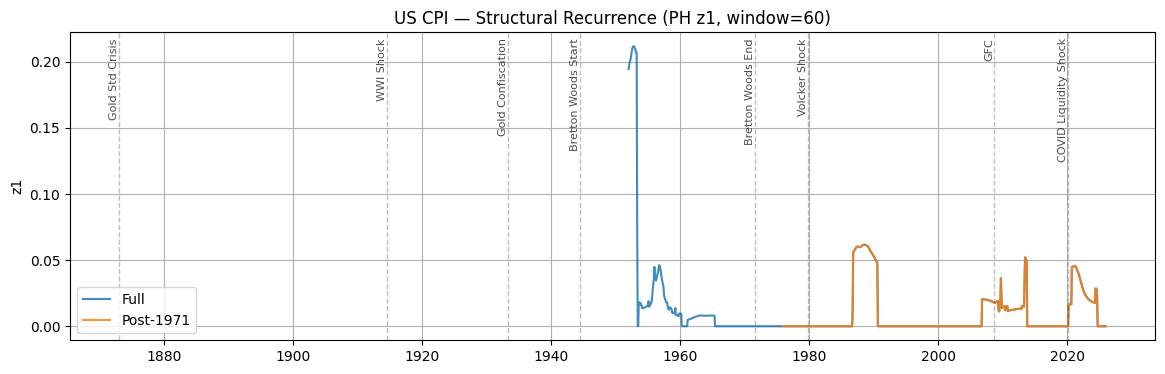

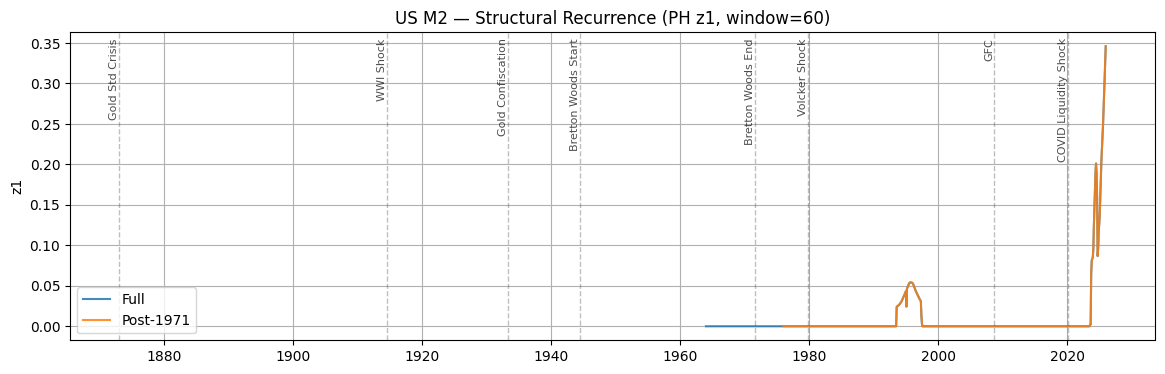

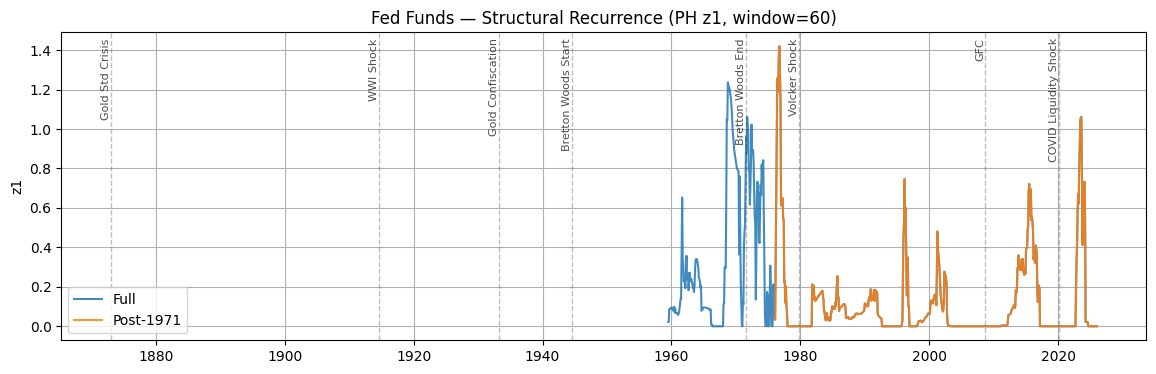

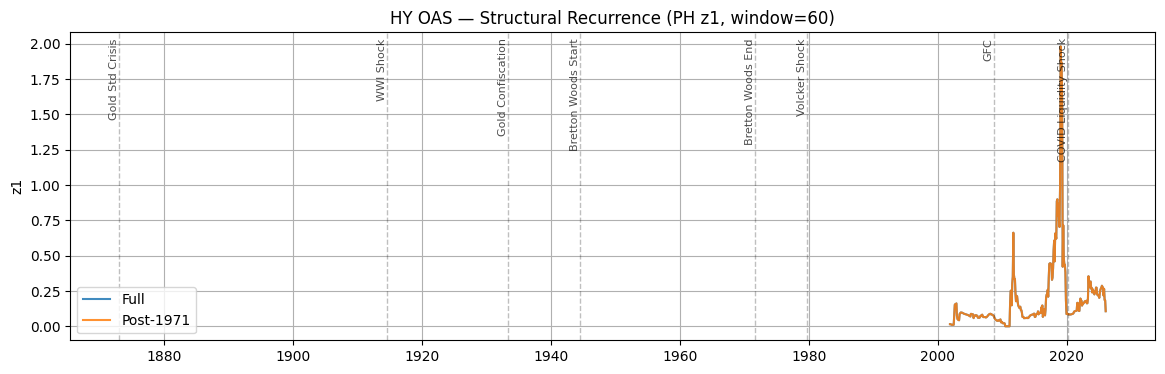

In [4]:
# 3. Structural PH z1 Plots

for asset in df_all["asset"].unique():
    g = df_all[df_all["asset"] == asset]

    fig, ax = plt.subplots(figsize=(14,4))
    for era, d in g.groupby("era"):
        ax.plot(d.index, d["z1"], label=era, alpha=0.85)

    meta = g.iloc[0]
    ax.set_title(
        f"{asset} — Structural Recurrence (PH z1, window={int(meta['window'])})"
    )
    ax.set_ylabel("z1")
    ax.legend()
    ax.grid(True)
    overlay_macro_events(ax)
    plt.show()

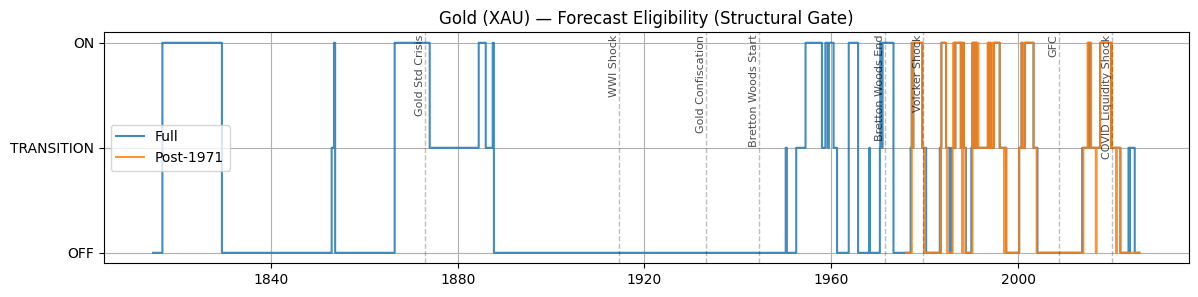

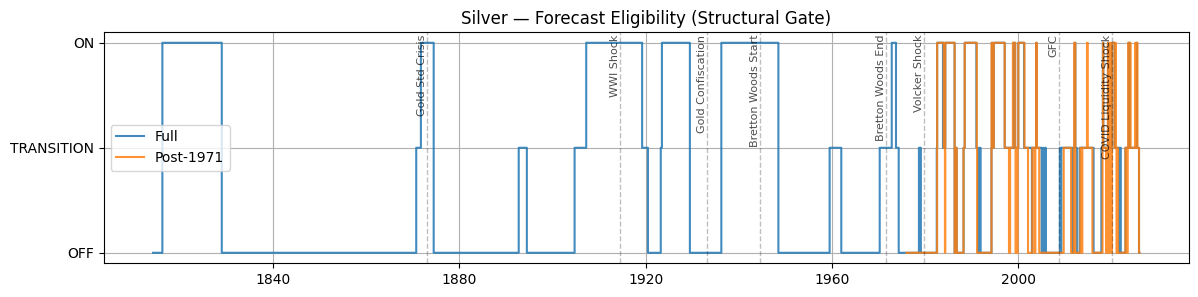

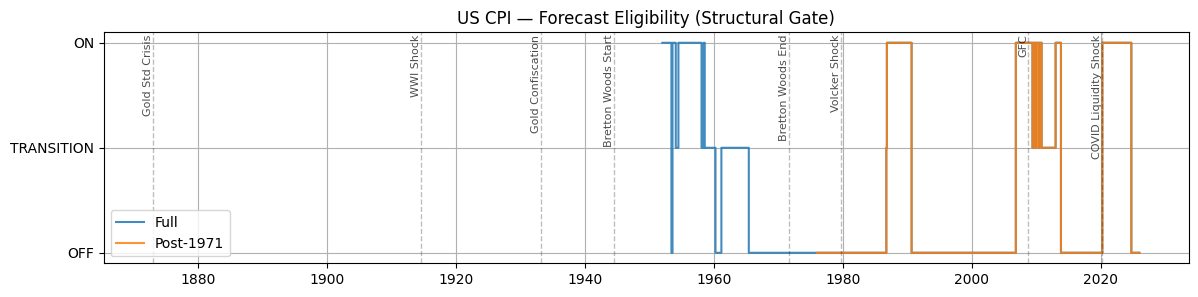

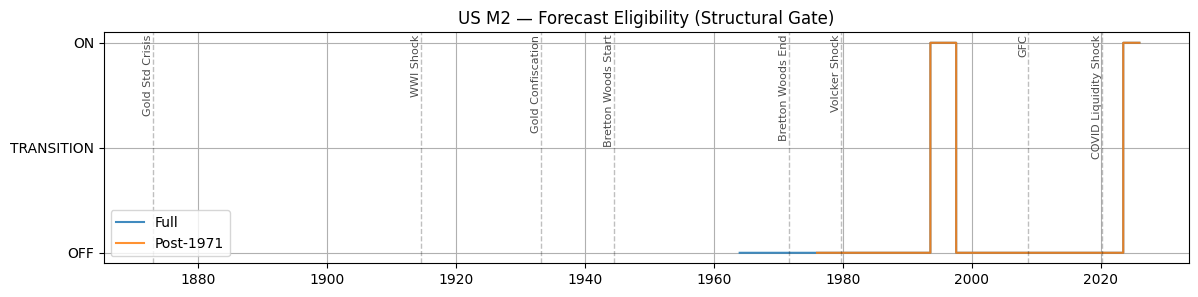

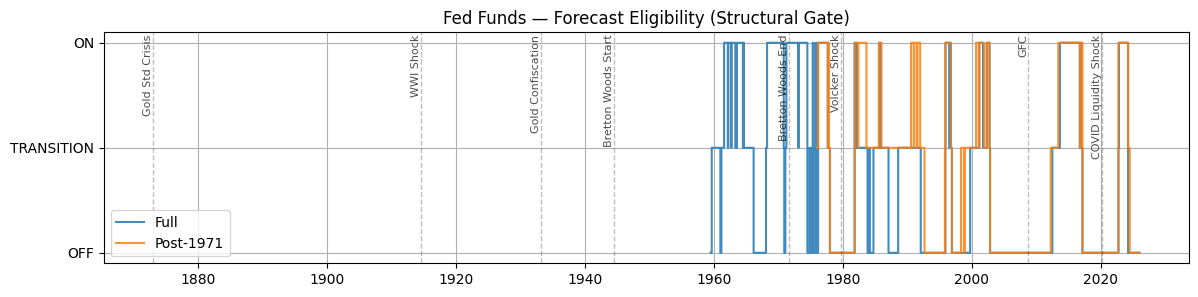

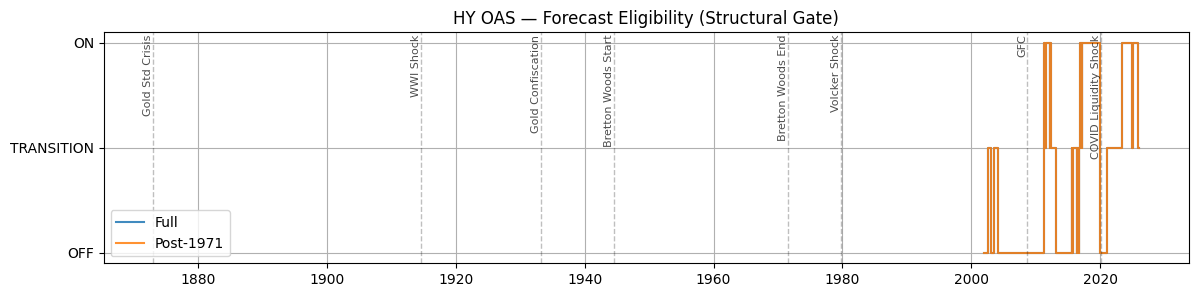

In [5]:
# ============================================================
# 4. Forecast Eligibility Regimes
# ============================================================

for asset in df_all["asset"].unique():
    g = df_all[df_all["asset"] == asset]

    fig, ax = plt.subplots(figsize=(14,3))
    for era, d in g.groupby("era"):
        ax.plot(
            d.index,
            d["forecast_state"],
            drawstyle="steps-post",
            label=era,
            alpha=0.85,
        )

    ax.set_yticks([-1, 0, 1])
    ax.set_yticklabels(["OFF", "TRANSITION", "ON"])
    ax.set_title(f"{asset} — Forecast Eligibility (Structural Gate)")
    ax.legend()
    ax.grid(True)
    overlay_macro_events(ax)
    plt.show()

In [6]:
# 5. Yield Curve (10y–2y) — Structural PH

print("\n=== Yield Curve (10y–2y) ===")

y10 = load_series_auto(PROJECT_ROOT / "data/raw/DGS10_Monthly.csv")
y2  = load_series_auto(PROJECT_ROOT / "data/raw/DGS2_Monthly.csv")

series_spread = (y10 - y2).dropna()

tau_cap = max(1, BASE_WINDOW // TAU_CAP_FRAC)
tau, m, _ = select_embedding_params(
    series_spread.values,
    max_tau=MAX_TAU,
    max_m=MAX_M,
    fnn_threshold=FNN_THRESHOLD,
    tau_cap=tau_cap,
)

window = max(BASE_WINDOW, (m - 1) * tau + 1)

df_spread_ph = rolling_ph(series_spread, window, STRIDE, m, tau)
df_spread_ph["forecast_state"] = forecast_eligibility(df_spread_ph["z1"])
df_spread_ph["asset"] = "Yield Curve (10y–2y)"
df_spread_ph["era"] = "Full"
df_spread_ph["window"] = window

results.append(df_spread_ph)


=== Yield Curve (10y–2y) ===


In [7]:
# 6. Summary Table

rows = []
for (asset, era), g in df_all.groupby(["asset", "era"]):
    stats = summarize_series(g["z1"].values)
    meta = g.iloc[0]

    rows.append({
        "asset": asset,
        "era": era,
        "window": int(meta["window"]),
        "m": int(meta["m"]),
        "tau": int(meta["tau"]),
        **stats,
        "usability": usability_score(stats["p90"], stats["cv"]),
    })

summary_df = (
    pd.DataFrame(rows)
    .sort_values("usability", ascending=False)
    .reset_index(drop=True)
)

summary_df

,asset,era,window,m,tau,mean,p90,std,cv,active_rate,usability
0,Fed Funds,Full,60,4,6,0.173753,0.606838,0.278075,1.600400,0.100125,0.379179
1,HY OAS,Full,60,4,6,0.184528,0.382325,0.255587,1.385087,0.103093,0.276030
2,HY OAS,Post-1971,60,4,6,0.184528,0.382325,0.255587,1.385087,0.103093,0.276030
3,Silver,Post-1971,60,4,6,0.097893,0.192953,0.071878,0.734245,0.101498,0.262791
4,Silver,Full,60,4,6,0.122499,0.313671,0.181997,1.485698,0.100614,0.211127
5,Gold (XAU),Post-1971,60,4,6,0.080222,0.177447,0.071219,0.887775,0.101498,0.199878
6,Fed Funds,Post-1971,60,4,6,0.115812,0.341238,0.217744,1.880151,0.101498,0.181495
7,Gold (XAU),Full,60,4,6,0.096872,0.221934,0.147024,1.517707,0.100000,0.146230
8,US CPI,Post-1971,60,2,6,0.009528,0.042658,0.017438,1.830255,0.100000,0.023307
9,US CPI,Full,60,2,6,0.012494,0.038525,0.030563,2.446151,0.100225,0.015749


In [8]:
# 7. Export for Notebook 06

EXPORT_PATH = PROJECT_ROOT / "data/processed"
EXPORT_PATH.mkdir(parents=True, exist_ok=True)

out_file = EXPORT_PATH / "structural_ph_outputs.csv"
df_all.to_csv(out_file)

print("Saved structural outputs to:", out_file.resolve())

Saved structural outputs to: /Users/Rod/Desktop/macro-cycle-scanner/cycle-tda-lab/data/processed/structural_ph_outputs.csv
